In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy

sns.set_palette("mako_r")  # prettier colors for histograms

df = pd.read_hdf("./../data/data-e215.h5", key="full")

In [2]:
# calculate D0 energy, momentum and invariant mass from its decay products
df["D0_E"] = df["k_E"] + df["pi_E"]
df["D0_px"] = df["k_px"] + df["pi_px"]
df["D0_py"] = df["k_py"] + df["pi_py"]
df["D0_pz"] = df["k_pz"] + df["pi_pz"]
df["D0_p"] = np.sqrt(df["D0_px"] ** 2 + df["D0_py"] ** 2 + df["D0_pz"] ** 2)
df["D0_M"] = np.sqrt(df["D0_E"] ** 2 - df["D0_p"] ** 2)

# calculate Dstar energy, momentum and invariant mass from its decay products
df["Dstar_E"] = df["D0_E"] + df["pis_E"]
df["Dstar_px"] = df["D0_px"] + df["pis_px"]
df["Dstar_py"] = df["D0_py"] + df["pis_py"]
df["Dstar_pz"] = df["D0_pz"] + df["pis_pz"]
df["Dstar_p"] = np.sqrt(df["Dstar_px"] ** 2 + df["Dstar_py"] ** 2 + df["Dstar_pz"] ** 2)
df["Dstar_M"] = np.sqrt(df["Dstar_E"] ** 2 - df["Dstar_p"] ** 2)

# calculate visible B energy, momentum and invariant mass from its visible decay products
df["Bvis_E"] = df["Dstar_E"] + df["Ls_E"]
df["Bvis_px"] = df["Dstar_px"] + df["Ls_px"]
df["Bvis_py"] = df["Dstar_py"] + df["Ls_py"]
df["Bvis_pz"] = df["Dstar_pz"] + df["Ls_pz"]
df["Bvis_p"] = np.sqrt(df["Bvis_px"] ** 2 + df["Bvis_py"] ** 2 + df["Bvis_pz"] ** 2)
df["Bvis_M"] = np.sqrt(df["Bvis_E"] ** 2 - df["Bvis_p"] ** 2)

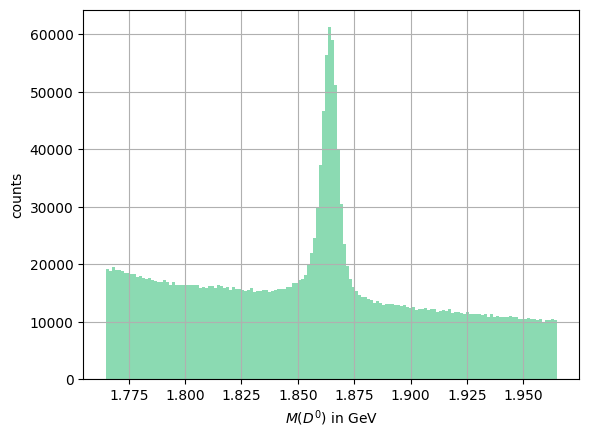

In [3]:
N_bins = 150

# plot D0 invariant mass without any cuts
plt.hist(df["D0_M"], bins=N_bins)
plt.xlabel(r"$M(D^0)$ in GeV")
plt.ylabel("counts")
plt.grid()

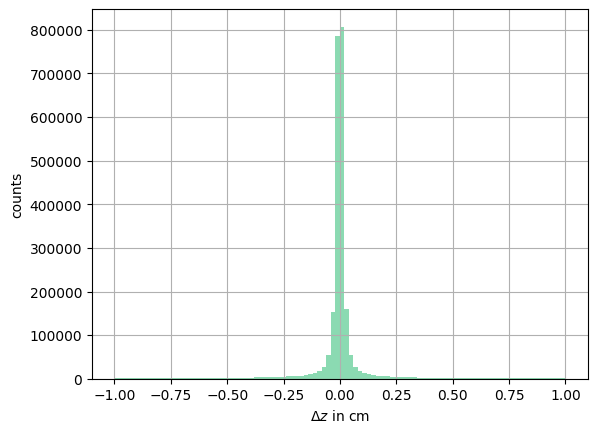

In [4]:
# examine position difference to find reasonable cut value
plt.hist(df["k_z0"] - df["pi_z0"], bins=100, range=(-1,1))
plt.xlabel(r"$\Delta z$ in cm")
plt.ylabel("counts")
plt.grid()

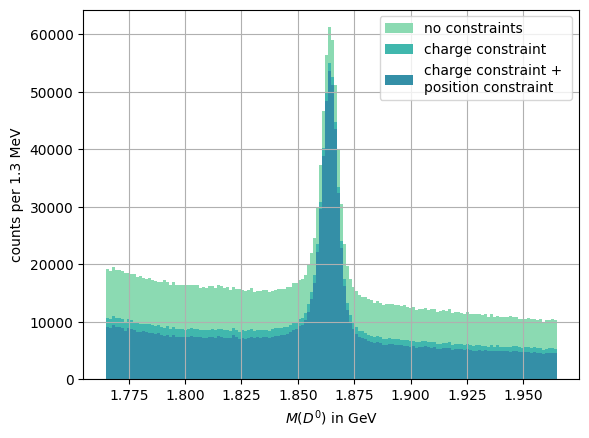

In [5]:
# no selection cuts
plt.hist(df["D0_M"], bins=N_bins, label="no constraints")

# kaon and pion should have opposite charge
q_cut = (df["k_q"] * df["pi_q"]) == -1
plt.hist(df.loc[q_cut]["D0_M"], bins=N_bins, label="charge constraint")

# difference in kaon and pion origin should be smaller than 1/8
z_cut = np.abs(df["k_z0"] - df["pi_z0"]) < 1/8
n, bins, _ = plt.hist(df.loc[q_cut & z_cut]["D0_M"], bins=N_bins, label="charge constraint + \nposition constraint")

plt.xlabel(r"$M(D^0)$ in GeV")
plt.ylabel("counts per %.1f MeV" %((bins[1] - bins[0]) * 1000))
plt.grid()
plt.legend()

# apply cuts to initial data frame
df_reduced1 = df.loc[q_cut & z_cut]

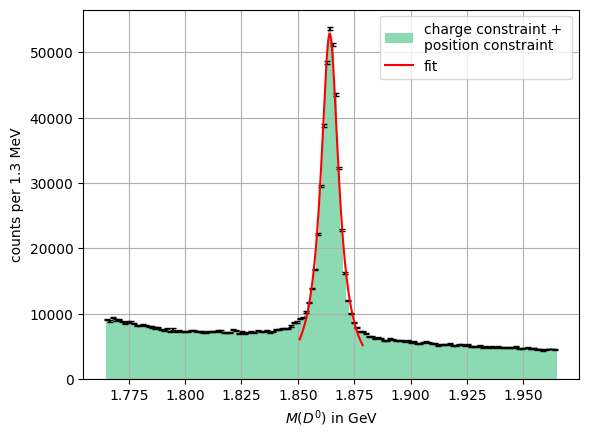

In [7]:
# fit peak of the invariant mass spectrum with a Lorentz function
def lorentz(x, a, x0, gamma):
    return a * gamma / ((x - x0) ** 2 + gamma ** 2)

bin_center = (bins[1:] + bins[:-1]) / 2
fit_range = (bin_center > 1.850) & (bin_center < 1.880)  # visually determined peak position

popt, pcov = curve_fit(lorentz, bin_center[fit_range], n[fit_range], sigma=np.sqrt(n[fit_range]))
perr = np.sqrt(np.diag(pcov))

m = popt[1]  # peak position = mass
gamma = popt[2]  # gamme ~ width

plt.hist(df_reduced1["D0_M"], bins=N_bins, label="charge constraint + \nposition constraint")
plt.errorbar(bin_center, n, np.sqrt(n), fmt="None", ecolor="k", capsize=2)
plt.plot(np.linspace(bin_center[fit_range][0], bin_center[fit_range][-1], 1000), lorentz(np.linspace(bin_center[fit_range][0], bin_center[fit_range][-1], 1000), *popt), "r-", label="fit")
plt.ylabel("counts per %.1f MeV" %((bins[1] - bins[0]) * 1000))
plt.xlabel(r"$M(D^0)$ in GeV")
plt.legend()
plt.grid()

(-2.029+/-0.035)e+04 (4.42+/-0.07)e+04


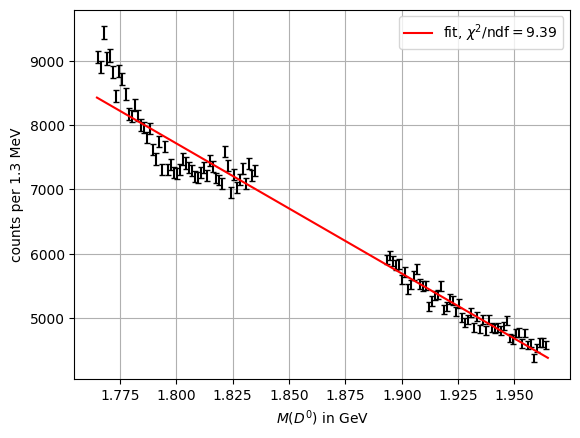

In [8]:

peak_fit = (bin_center < (m + 6 * gamma)) & (bin_center > (m - 6 * gamma))  # mask for the peak position

# fit linear background without taking into account events within a 6 gamma (=3 FWHM) interval around the peak
def linear(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear, bin_center[~peak_fit], n[~peak_fit], sigma=np.sqrt(n[~peak_fit]))
perr = np.sqrt(np.diag(pcov))

a = ufloat(popt[0], perr[0])
b = ufloat(popt[1], perr[1])
print(a, b)

res = linear(bin_center[~peak_fit], *popt) - n[~peak_fit]
chi2 = np.sum(res**2 / np.sqrt(n[~peak_fit])**2)
chi2_ndf = chi2 / (len(res) - len(popt))

plt.errorbar(bin_center[~peak_fit], n[~peak_fit], np.sqrt(n[~peak_fit]), fmt="None", ecolor="k", capsize=2)
plt.plot(np.linspace(bins[0], bins[-1], 1000), linear(np.linspace(bins[0], bins[-1], 1000), *popt), "r-", label=r"fit, $\chi^2 / \text{ndf} = %.2f$" % chi2_ndf)
plt.ylabel("counts per %.1f MeV" %((bins[1] - bins[0]) * 1000))
plt.xlabel(r"$M(D^0)$ in GeV")
plt.legend()
plt.grid()

In [9]:
peak = (bin_center < (m + 3 * gamma)) & (bin_center > (m - 3 * gamma))  # mask for the peak position

# calculate number of singal candidates, number of background events and purity
N_total = ufloat(np.sum(n[peak]), np.sum(np.sqrt(n[peak])))
N_background = np.sum(linear(bin_center[peak], a, b))
purity = (N_total - N_background) / N_total
print(purity)

0.72+/-0.04


In [10]:
peak_mask = (df["D0_M"] < (m + 3 * gamma)) & (df["D0_M"] > (m - 3 * gamma))

D0_p_peak = np.mean(df_reduced1.loc[peak_mask]["D0_p"])
D0_p_sideband = np.mean(df_reduced1.loc[~peak_mask]["D0_p"])

print(D0_p_peak, D0_p_sideband)

D0_p_average = (D0_p_peak - (1 - purity) * D0_p_sideband) / purity
print(D0_p_average)

# sigma = (purity * (1 - purity) / N_total) ** (1/2)
# print(sigma)

1.6051459017859033 1.3638835814665489
1.701+/-0.019


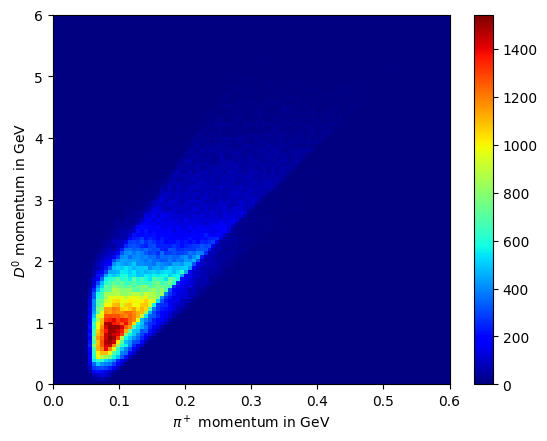

In [11]:
# reduce the data frame further by getting rid of the side bands
df_reduced2 = df_reduced1.loc[peak_mask]

plt.hist2d(df_reduced2["pis_p"], df_reduced2["D0_p"], bins=(100,100), range=[[0, 0.6], [0, 6]], cmap=plt.cm.jet)
plt.xlabel(r"$\pi^+$ momentum in GeV")
plt.ylabel(r"$D^0$ momentum in GeV")
plt.colorbar()

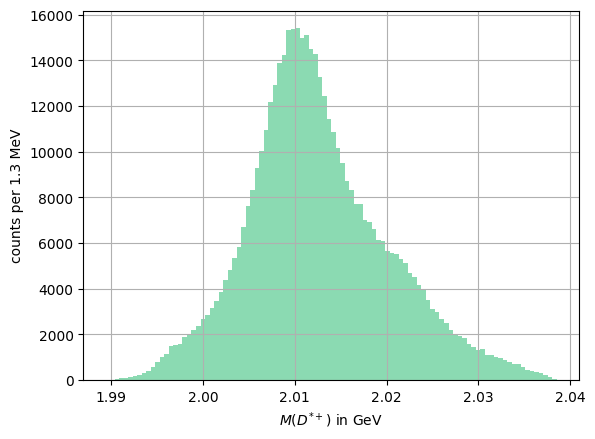

In [12]:
# plot Dstar invariant mass of the reduced data frame
plt.hist(df_reduced2["Dstar_M"], bins=100)
plt.ylabel("counts per %.1f MeV" %((bins[1] - bins[0]) * 1000))
plt.xlabel(r"$M(D^{*+})$ in GeV")
plt.grid()

/tmp/ipykernel_8182/2219653308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced2["M_diff"] = df_reduced2["Dstar_M"] - df_reduced2["D0_M"]


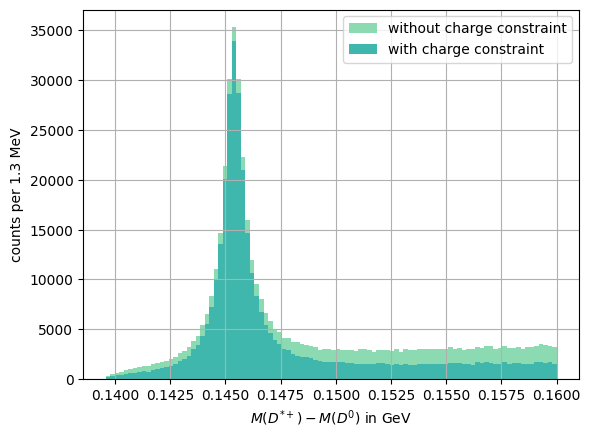

In [13]:
N_bins = 100

# calculate and plot the difference between the Dstar and the D0 mass
df_reduced2["M_diff"] = df_reduced2["Dstar_M"] - df_reduced2["D0_M"]
q_cut2 = df_reduced2["pi_q"] == df_reduced2["pis_q"]
plt.hist(df_reduced2["M_diff"], bins=N_bins, label="without charge constraint")
n2, bins2, _ = plt.hist(df_reduced2.loc[q_cut2]["M_diff"], bins=N_bins, label="with charge constraint")
plt.ylabel("counts per %.1f MeV" %((bins[1] - bins[0]) * 1000))
plt.xlabel(r"$M(D^{*+}) - M(D^0)$ in GeV")
plt.legend()
plt.grid()

df_reduced3 = df_reduced2.loc[q_cut2]

In [14]:
bin_center2 = (bins2[1:] + bins2[:-1]) / 2
fit_range = (bin_center2 > 0.1430) & (bin_center2 < 0.1480)  # visually determined peak range
bin_center3, n3 = bin_center2[fit_range], n2[fit_range]

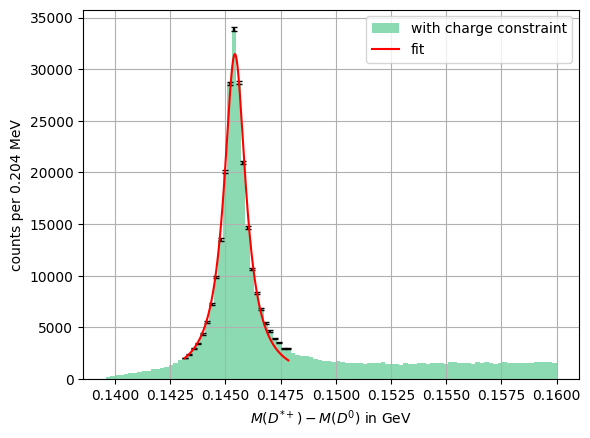

In [15]:
# fit mass difference peak with a Lorentz function
popt, pcov = curve_fit(lorentz, bin_center3, n3, sigma=np.sqrt(n3))
perr = np.sqrt(np.diag(pcov))

m = popt[1]
gamma = popt[2]

plt.hist(df_reduced3["M_diff"], bins=N_bins, label="with charge constraint")
plt.errorbar(bin_center3, n3, np.sqrt(n3), fmt="None", ecolor="k", capsize=2)
plt.plot(np.linspace(bin_center3[0], bin_center3[-1], 1000), lorentz(np.linspace(bin_center3[0], bin_center3[-1], 1000), *popt), "r-", label="fit")
plt.ylabel("counts per %.3f MeV" %((bins2[1] - bins2[0]) * 1000))
plt.xlabel(r"$M(D^{*+}) - M(D^0)$ in GeV")
plt.legend()
plt.grid()

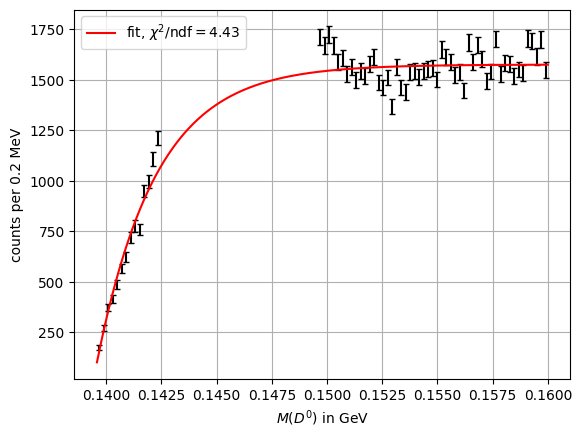

In [16]:
peak2 = (bin_center2 < (m + 7 * gamma)) & (bin_center2 > (m - 5 * gamma))

def func3(x, a, b, c):
    return a * (1 - np.exp(b * (x - c)))

popt, pcov = curve_fit(func3, bin_center2[~peak2], n2[~peak2], sigma=np.sqrt(n2[~peak2]), p0=(np.mean(n[:-20]), -1, bin_center2[0]))
perr = np.sqrt(np.diag(pcov))

# a = ufloat(popt[0], perr[0])
# b = ufloat(popt[1], perr[1])
# c = ufloat(popt[2], perr[2])
# print(a, b, c)

res = func3(bin_center2[~peak2], *popt) - n2[~peak2]
chi2 = np.sum(res**2 / np.sqrt(n2[~peak2])**2)
chi2_ndf = chi2 / (len(res) - len(popt))

plt.errorbar(bin_center2[~peak2], n2[~peak2], np.sqrt(n2[~peak2]), fmt="None", ecolor="k", capsize=2)
plt.plot(np.linspace(bins2[0], bins2[-1], 1000), func3(np.linspace(bins2[0], bins2[-1], 1000), *popt), "r-", label=r"fit, $\chi^2 / \text{ndf} = %.2f$" % chi2_ndf)
plt.ylabel("counts per %.1f MeV" %((bins2[1] - bins2[0]) * 1000))
plt.xlabel(r"$M(D^0)$ in GeV")
plt.legend()
plt.grid()

In [17]:
peak2 = (bin_center2 < (m + 3 * gamma)) & (bin_center2 > (m - 3 * gamma))  # mask for the peak position

# calculate number of singal candidates, number of background events and purity
N_total = ufloat(np.sum(n2[peak2]), np.sum(np.sqrt(n2[peak2])))
N_background = np.sum(func3(bin_center2[peak2], *popt))
purity = (N_total - N_background) / N_total
print(purity)

0.8957+/-0.0009


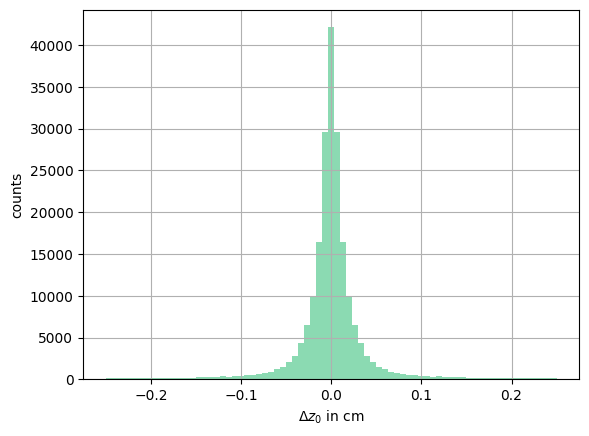

In [18]:
peak_mask = (df_reduced3["M_diff"] < (m + 3 * gamma)) & (df_reduced3["M_diff"] > (m - 3 * gamma))
df_reduced4 = df_reduced3.loc[peak_mask]

plt.hist(df_reduced4["Ls_z0"] - df_reduced4["Lt_z0"], bins=75, range=(-0.25, 0.25))
plt.xlabel(r"$\Delta z_0$ in cm")
plt.ylabel("counts")
plt.grid()

/tmp/ipykernel_8182/3888716249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced4["Dstar_z0"] = (df_reduced4["k_z0"] + df_reduced4["pi_z0"] + df_reduced4["pis_z0"]) / 3


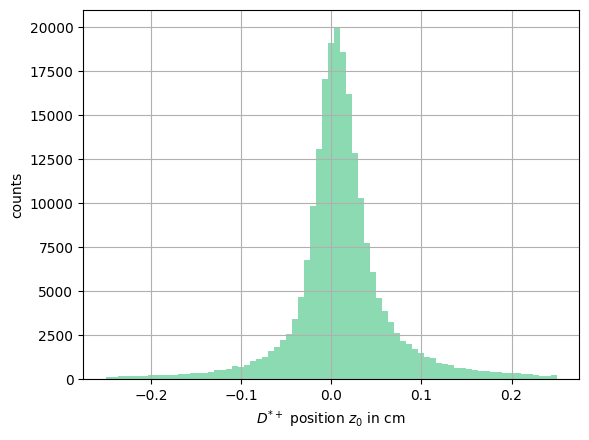

In [19]:
df_reduced4["Dstar_z0"] = (df_reduced4["k_z0"] + df_reduced4["pi_z0"] + df_reduced4["pis_z0"]) / 3

plt.hist(df_reduced4["Dstar_z0"], bins=75, range=(-0.25, 0.25))
plt.xlabel("$D^{*+}$ position $z_0$ in cm")
plt.ylabel("counts")
plt.grid()

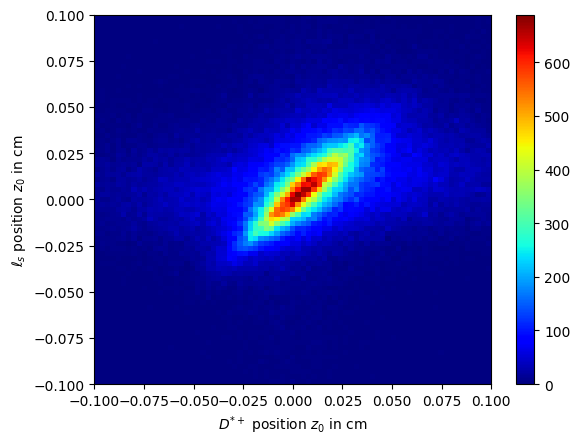

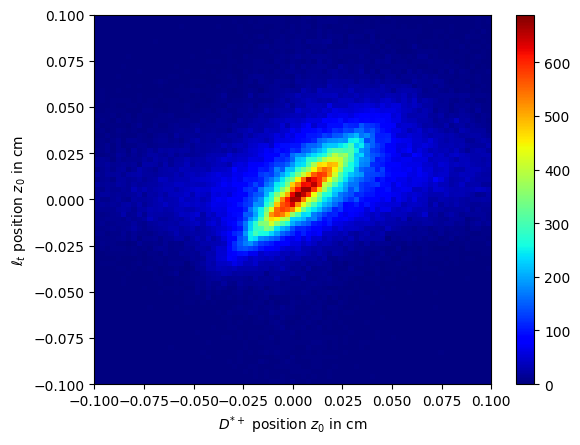

In [20]:
plt.hist2d(df_reduced4["Dstar_z0"], df_reduced4["Ls_z0"], bins = (75, 75), range=[[-0.1, 0.1], [-0.1, 0.1]], cmap=plt.cm.jet)
plt.xlabel("$D^{*+}$ position $z_0$ in cm")
plt.ylabel("$\ell_s$ position $z_0$ in cm")
plt.colorbar()
plt.show()

plt.hist2d(df_reduced4["Dstar_z0"], df_reduced4["Lt_z0"], bins = (75, 75), range=[[-0.1, 0.1], [-0.1, 0.1]], cmap=plt.cm.jet)
plt.xlabel("$D^{*+}$ position $z_0$ in cm")
plt.ylabel("$\ell_t$ position $z_0$ in cm")
plt.colorbar()
plt.show()

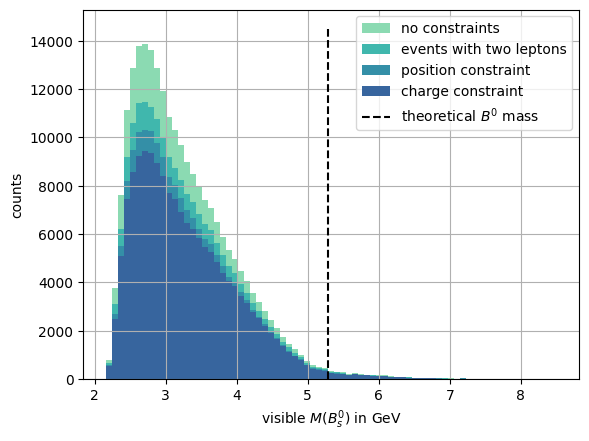

In [21]:
B_mass = 5.28  # literature value

# plot visible part of the invariant B0 mass (without the neutrino); first without any constraints
plt.hist(df_reduced4["Bvis_M"], bins=75, label="no constraints")

# only consider decays with two leptons
n_lep_cut = df_reduced4["nlep"] == 2
plt.hist(df_reduced4.loc[n_lep_cut]["Bvis_M"], bins=75, label="events with two leptons")

# origins of the two leptons should be close together
z_diff_cut = (df_reduced4["Ls_z0"] - df_reduced4["Lt_z0"]) < 0.05
plt.hist(df_reduced4.loc[n_lep_cut & z_diff_cut]["Bvis_M"], bins=75, label="position constraint")

# if the two leptons have the same charge (i.e. the B0 counts as oscillated), then the lepton should have the same charge as the slow pion
lep_pis_q_cut = (df_reduced4["Ls_q"] == df_reduced4["Lt_q"]) & (df_reduced4["Ls_q"] == df_reduced4["pis_q"])
plt.hist(df_reduced4.loc[n_lep_cut & z_diff_cut & ~lep_pis_q_cut]["Bvis_M"], bins=75, label="charge constraint")

plt.vlines(B_mass, plt.axis()[2], plt.axis()[3], colors="k", linestyles="dashed", label=r"theoretical $B^0$ mass")
plt.xlabel(r"visible $M(B^0_s)$ in GeV")
plt.ylabel("counts")
plt.legend()
plt.grid()

mass_cut = df_reduced4["Bvis_M"] < B_mass  # exclude events with an invariant mass larger than the B0 mass
df_reduced5 = df_reduced4.loc[n_lep_cut & z_diff_cut & mass_cut]

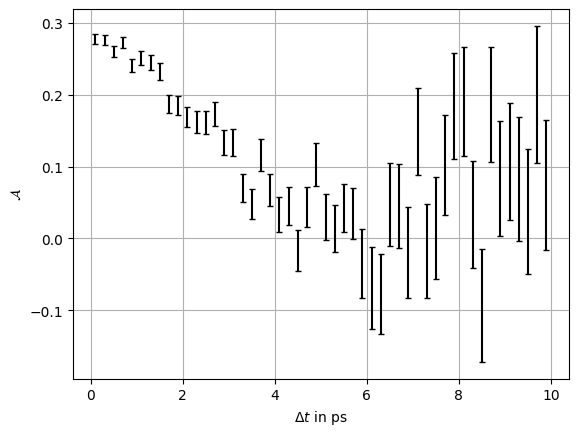

In [22]:
lep_q_cut = df_reduced5["Lt_q"] == df_reduced5["Ls_q"]

# divide the data into two subsets ("oscillated" and "not-oscillated" B0) according to the charge of the leptons
df_osc = df_reduced5.loc[lep_q_cut]
df_notosc = df_reduced5.loc[~lep_q_cut]

n_osc, bin_edges_osc = np.histogram(df_osc["deltat"], bins=50, range=(0, 10))
n_notosc, bin_edges_notosc = np.histogram(df_notosc["deltat"], bins=50, range=(0, 10))

N_osc = unumpy.uarray(n_osc, np.sqrt(n_osc))
N_notosc = unumpy.uarray(n_notosc, np.sqrt(n_notosc))
A = (N_notosc - N_osc) / (N_notosc + N_osc)
dt = (bin_edges_osc[1:] + bin_edges_osc[:-1]) / 2

plt.errorbar(dt, unumpy.nominal_values(A), unumpy.std_devs(A), fmt="None", ecolor="k", capsize=2, label="data")
plt.xlabel(r"$\Delta t$ in ps")
plt.ylabel(r"$\mathcal{A}$")
plt.grid()

0.539+/-0.017 0.136+/-0.006 0.133+/-0.006


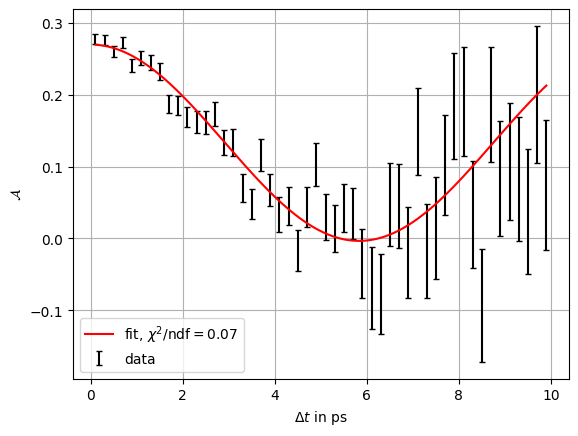

In [23]:
def oscillation(t, DeltaM, a , b):
    return a * np.cos(DeltaM * t) + b

popt, pcov = curve_fit(oscillation, dt, unumpy.nominal_values(A), sigma = unumpy.std_devs(A))
perr = np.sqrt(np.diag(pcov))

res = oscillation(dt, *popt) - unumpy.nominal_values(A)
chi2 = np.sum(res**2 / unumpy.std_devs(A))
chi2_ndf = chi2 / (len(res) - len(popt))

DeltaM = ufloat(popt[0], perr[0])
a = ufloat(popt[1], perr[1])
b = ufloat(popt[2], perr[2])
print(DeltaM, a, b)

plt.errorbar(dt, unumpy.nominal_values(A), unumpy.std_devs(A), fmt="None", ecolor="k", capsize=2, label="data")
plt.plot(np.linspace(dt[0], dt[-1], 1000), oscillation(np.linspace(dt[0], dt[-1], 1000), *popt), "r-", label=r"fit, $\chi^2 / \text{ndf} = %.2f$" %chi2_ndf)
plt.xlabel(r"$\Delta t$ in ps")
plt.ylabel(r"$\mathcal{A}$")
plt.legend()
plt.grid()